# `rloop` sensor filter design notebook

We want to design filters to suppress wideband noise within our sensor readings without sacrificing sensor system responsiveness by blurring the readings too much.  In particular, we want strong stopband suppression while retaining good step response such that we can still react to changes from our sensors in a timely manner.  The requirements for sensor systems are different respective to the application of the particular sensor, and so we develop here a general framework that allows us to generate filter coefficients for each sensor parameterized by the maximum cutoff frequency, rise time, and sampling rate per system.

### Notebook info
This notebook was run using `python 3.6` on OSX, but should run anywhere you can install `python`, `numpy`, `scipy` and `matplotlib`.

In [1]:
%matplotlib inline
# Start with some setup, let's import the libraries we'll use to do our calculations
from numpy import *
from scipy import *
from scipy.signal import *
from matplotlib.pyplot import *
import os.path, csv

# Filter testing rig

We will test our filters by examining the frequency response and the impulse/step response.  We are particularly interested in whether the spectral content above the cutoff frequency (in this case, 20 Hz) is adequately attentuated, and whether the rise time (the time after a step function activates until the filter output reaches 90% of the steady-state output) is within the specified threshold (in this case, 50ms)

In [2]:
def impulse_response(b, a, N):
    # If all we cared about were FIR filters, we could just use `b`.
    # But IIR it's easiest to just run an impulse through:
    impulse = hstack([1, zeros(N-1)])
    return lfilter(b, a, impulse)

def step_response(b, a, N):
    step = ones(N)
    return lfilter(b, a, step)

def db(x):
    return 20*log10(x)

def plot_filter(b, a, fs, fc=20, f_stop=45, L=100, name=None):
    # Calculate things like the impulse response, the frequency response, etc...
    imp_resp = impulse_response(b, a, L)
    step_resp = step_response(b, a, L)
    freq_resp = fft(imp_resp)
    freqs = arange(L/2)*fs/L
    times = arange(L)/fs
    
    # First, plot (positive, magnitude) frequency response
    subplot(221)
    fill_between([0,        fc], 0, 1, facecolor='green', alpha=0.05)
    fill_between([f_stop, fs/2], 0, 1, facecolor='red', alpha=0.05)
    plot([20, 20], [0, 1], 'k--', alpha=0.3)
    plot(freqs, abs(freq_resp[:int(L/2)]), label=name)
    xlim(0, fs/2)
    ylim(0, 1)
    xlabel('Frequency (Hz)')
    ylabel('Linear Frequency Response')
    legend()
    
    # Next, plot (positive, log-magnitude) frequency response
    subplot(222)
    fill_between([0,        fc], -140, 0, facecolor='green', alpha=0.05)
    fill_between([f_stop, fs/2], -140, 0, facecolor='red', alpha=0.05)
    plot([20, 20], [-140, 0], 'k--', alpha=0.3)
    plot(freqs, db(abs(freq_resp[:int(L/2)])), label=name)
    xlim(0, fs/2)
    ylim(-140, 0)
    xlabel('Frequency (Hz)')
    ylabel('Log Frequency Response')
    legend()
    
    # Next, plot impulse response
    subplot(223)
    plot(times*1000, imp_resp, label=name)
    xlabel('Time (ms)')
    ylabel('Impulse Response')
    xlim(0, 100)
    ylim(min(imp_resp), 1)
    legend()
    
    # And also step response
    subplot(224)
    plot(times*1000, step_resp, label=name)
    plot([50, 50], [0, 1], 'k--', alpha=0.5)
    xlabel('Time (ms)')
    ylabel('Step Response')
    xlim(0, 100)
    ylim(-.1, 1.1)
    legend()

# Filter Type I: FIR Filters

FIR (Finite Impulse Response) filters are the simplest type of filter, calculating the output value off of a finite list of previous inputs.  Mathematically, we define:

$$
y[i] = \sum_{k=0}^{N}{x[i-k] \cdot b[k]}
$$

where $x$ is the array of input, $y$ is the array of output, and $b$ is a weights vector.  Our FIR filter design will find this weight vector through the application of window-based filter design.

In [45]:
# We define a function to spit out a filter design given three pieces of information:
#         fs: Sample rate in Hz
#        f_c: Cutoff frequency (in Hz)
#  rise_time: rise time (in seconds)
#
# Returns (b, a), but because this is an FIR filter, a is just [1], and b is the
# weight vector shown above
def fir_design(fs, fc, rise_time, window='nuttall'):
    # Given a rise time, we can immediately calculate the length of the filter;
    # A linear-phase FIR filter (which is what we're generating here) has a group
    # delay of (N-1)/(2*fs), where N is the length of the filter.  The group delay
    # tells us where the centroid of the impulse response will be (in seconds),
    # which also, by definition, corresponds to the 50% rise time point. A good
    # guess for N is therefore to invert the relation, and multiply by 1.5 to
    # hit the midpoint between the 50% rise time point, and 100%.  This is a
    # little bit more art than science, although we could just search over N
    # to find one that gives us a perfect result.
    N = round(1.5*(rise_time * fs + 1))
    if N%2 == 0:
        N += 1
    
    return firwin(N, fc, window=window, nyq=fs/2.0), array([1])

# Filter Type II: IIR Filters

IIR (Infinite Impulse Response) filters are a slightly more complicated type of filter, calculating the output value from a finie list of previous inputs as well as a finite list of previous outputs.  Mathematically, we define:

$$
y[i] = \sum_{k=0}^{N} {x[i-k] \cdot b[k]} + \sum_{j=1}^{M} {y[i-j] \cdot a[j]}
$$

where $x$ is the array of input, $y$ is the array of output, and $b$ and $a$ are weights vectors.  Our IIR filter design will find this weight vector through the use of a Bessel filter calculation routine, as Bessel filters are known to converge with a relative minimum of ringing.

In [46]:
# We define a function to spit out a filter design given three pieces of information:
#         fs: Sample rate in Hz
#        f_c: Cutoff frequency (in Hz)
#  rise_time: rise time (in seconds)
#
# Returns (b, a), the coefficients needed for filtering
def iir_design(fs, fc, rise_time):
    # Similar argument to the one above for fir_design(), but this has more to
    # do with "tried this value and it worked well" then any kind of math
    # argument.
    N = round(.7*fs*rise_time)
    return bessel(N, fc/(fs/2))

# FIR and IIR results

FIR coefficients of length 17:
  h: [-0.00001588,-0.00020811,-0.00090940,0.00000000,0.01228401,0.05188116,0.12293536,0.19833134,0.23140305,0.19833134,0.12293536,0.05188116,0.01228401,0.00000000,-0.00090940,-0.00020811,-0.00001588]

IIR coefficients of length 8:
  a: [1.00000000,-3.94695130,6.96138173,-7.06524279,4.43453407,-1.71475392,0.37708315,-0.03628781]
  b: [0.00007627,0.00053392,0.00160176,0.00266961,0.00266961,0.00160176,0.00053392,0.00007627]


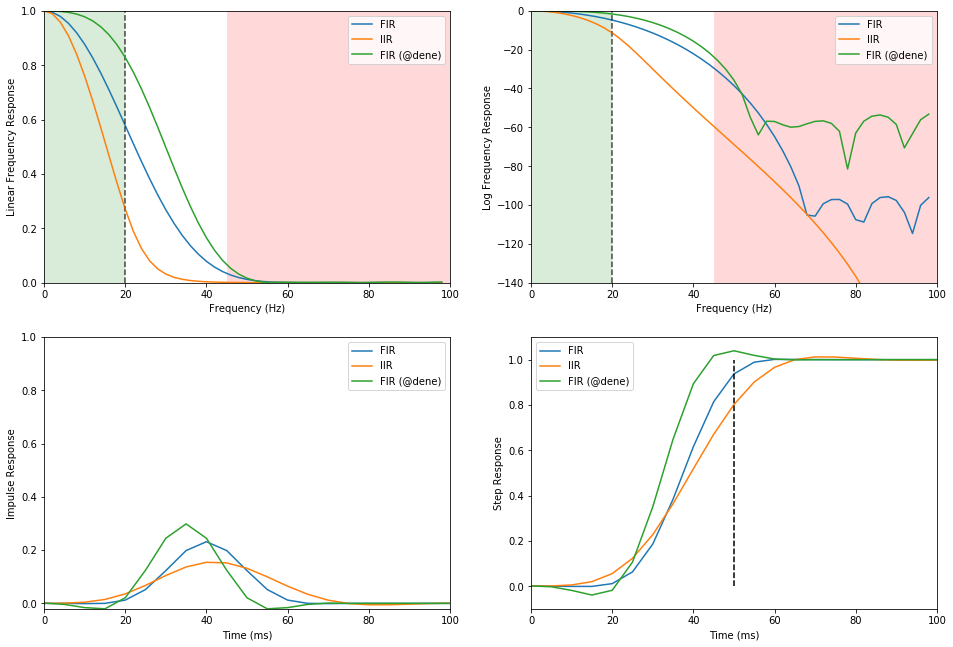

In [47]:
# We sample at 200 Hz, we want to preserve spectral energy under 20 Hz,
# and we need to see a change in at least 50 ms, although we shoot for faster
fs = 200
f_c = 20
rise_time = .05

b_fir, a_fir = fir_design(fs, f_c, rise_time)
b_iir, a_iir = iir_design(fs, f_c, rise_time)

# Also compare @dene's filter
b_dene = array([0.0011, -0.0039, -0.0160, -0.0204, 0.0210,
                0.1245,  0.2445,  0.2984,  0.2445, 0.1245,
                0.0210, -0.0204, -0.0160, -0.0039, 0.0011])
a_dene = array([1])


figure(figsize=(16,11))
plot_filter(b_fir, a_fir, fs, name="FIR")
plot_filter(b_iir, a_iir, fs, name="IIR")
plot_filter(b_dene, a_dene, fs, name="FIR (@dene)")

# Let's print out the filter coefficients as well
b_fir_str = ",".join(["%.8f"%(x) for x in b_fir])
print("FIR coefficients of length %d:\n  h: [%s]"%(len(b_fir), b_fir_str))
print()

a_iir_str = ",".join(["%.8f"%(x) for x in a_iir])
b_iir_str = ",".join(["%.8f"%(x) for x in b_iir])
print("IIR coefficients of length %d:\n  a: [%s]\n  b: [%s]"%(len(b_iir), a_iir_str, b_iir_str))

# Synthetic Tests

We build a synthetic testing signal, add some Gaussian White Noise to it and see what it looks like

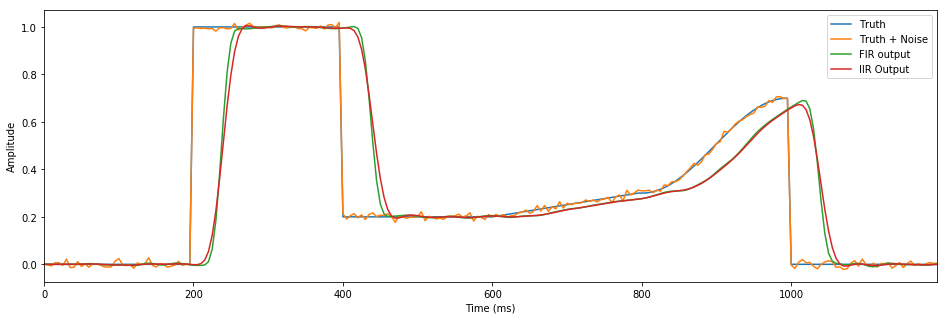

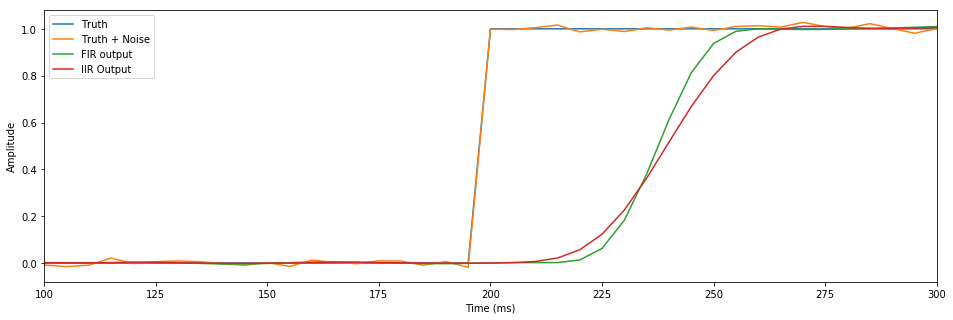

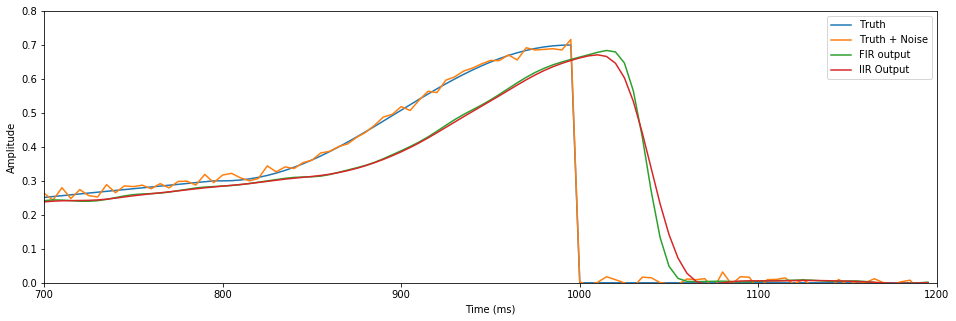

In [6]:
def plot_filtered_signal(truth):
    # We assume a sampling rate of 200 Hz, to stay consistent
    fs = 200
    # t is in milliseconds
    t = arange(len(truth))*1000/fs
    noisy = truth + .01*randn(len(truth))

    fir_filt = lfilter(b_fir, a_fir, noisy)
    iir_filt = lfilter(b_iir, a_iir, noisy)

    figure(figsize=(16,5))
    plot(t, truth)
    plot(t, noisy)
    plot(t, fir_filt)
    plot(t, iir_filt)
    xlim(0, t[-1])
    xlabel("Time (ms)")
    ylabel("Amplitude")
    legend(["Truth", "Truth + Noise", "FIR output", "IIR Output"])

# Generate test data
N = 40
ground_truth = hstack([
    zeros(N),
    1*ones(N),
    .2*ones(N),
    linspace(.2, .3, N),
    .2*(1 - cos(linspace(0,pi,N))) + .3,
    zeros(N)
])
plot_filtered_signal(ground_truth)

# Make a second plot, zoom in on first discontinuity
plot_filtered_signal(ground_truth)
xlim(100, 300)

# Make a third plot, zoom in on sin ramp
plot_filtered_signal(ground_truth)
xlim(700, 1200)
ylim(0, .8);

# Naturalistic Tests

We load in some .csv files containing actual Accelerometer data to see what they look like, and to run them through some of our filters.

In [7]:
csv_path = os.path.join("..", "..", "TEST_DATA", "2016_11_17", "accel_laser_data.csv")

# These channels informed by `filter_laser_data.py` in the `TEST_DATA/2016_11_17` folder.
accel_data = {
    'x': [],
    'y': [],
    'z': [],
}
laser_data = {
    'l_aft_height': [],
    'r_aft_height': [],
    'aft_yaw': [],
}
with open(csv_path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        accel_data['x'].append(float(row[1]))
        accel_data['y'].append(float(row[2]))
        accel_data['z'].append(float(row[3]))
        laser_data['l_aft_height'].append(float(row[4]))
        laser_data['r_aft_height'].append(float(row[5]))
        laser_data['aft_yaw'].append(float(row[6]))

for k in accel_data.keys():
    accel_data[k] = array(accel_data[k])
for k in laser_data.keys():
    laser_data[k] = array(laser_data[k])

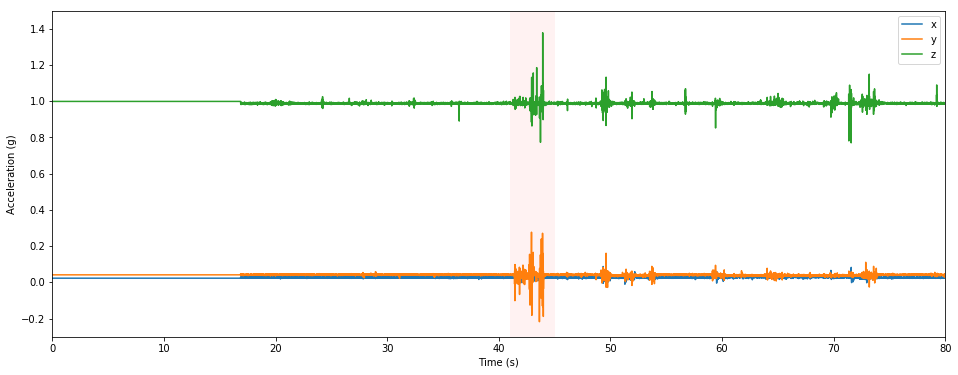

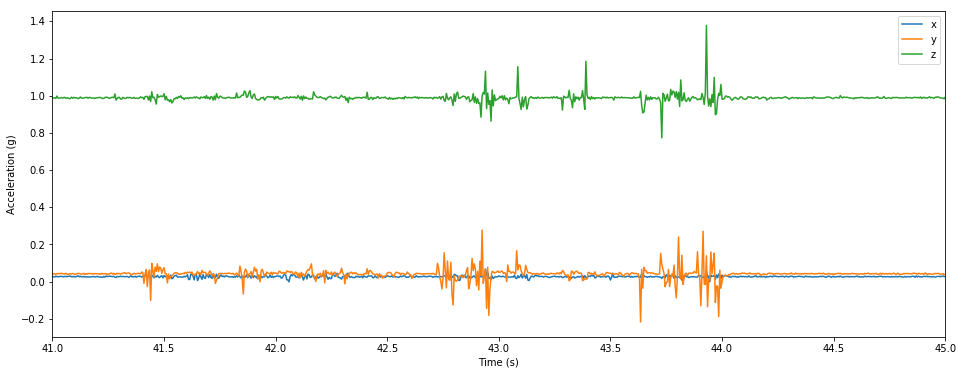

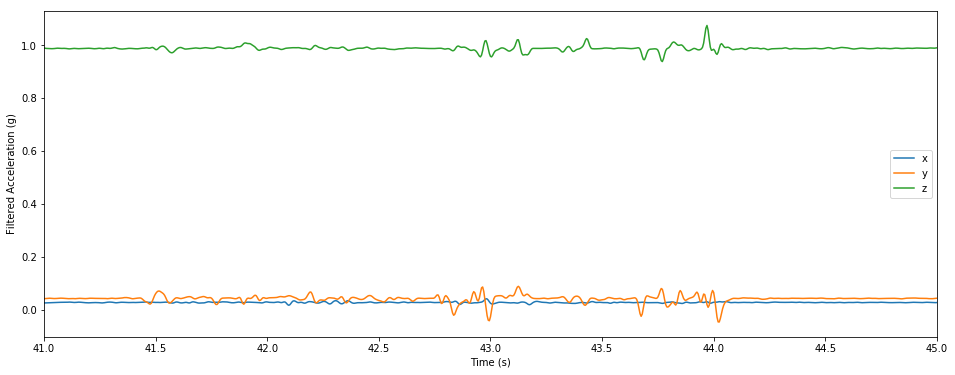

In [8]:
# We assume sampling rate of 200 Hz
fs = 200

def plot_dict(data):
    figure(figsize=(16,6))
    for k in data.keys():
        t = arange(len(data[k]))/fs
        plot(t, data[k], label=k)
        legend()
        
def filter_dict(b, a, data):
    return {k: lfilter(b, a, data[k]) for k in data.keys()}
    
    
# Plot the data, but manually zoom in on something interesting
plot_dict(accel_data)
fill_between([41, 45], -.3, 1.5, facecolor='red', alpha=0.05)
xlim(0, 80)
ylim(-.3, 1.5)
xlabel('Time (s)')
ylabel('Acceleration (g)');


plot_dict(accel_data)
xlim(41, 45)
xlabel('Time (s)')
ylabel('Acceleration (g)');

fir_accel_data = filter_dict(b_fir, a_fir, accel_data)
plot_dict(fir_accel_data)
xlim(41, 45)
xlabel('Time (s)')
ylabel('Filtered Acceleration (g)');

# Filter actualization

We want to filter the signals in C/C++ where we don't have the benefit of `lfilter()` and friends, so given just the raw coefficients we will filter the incoming stream sample-by-sample.  The main API for this is to just call a function that takes a single sample in, then returns a single sample out, maintaining buffers of previously used samples within the filtering routine itself.

We use fixed-point math throughout, to simulate the microcontroller environment.  We normalize our input data and coefficients to `s16` format, then perform the filtering computation as `s32` data, converting back to `float32` for plotting and comparison outside of the function.  The computation is general, feel free to substitute in whatever computation datatype and normalization bitdepth you wish.  Note that we actually normalize to `2**14` to keep one bit for the sign of the number, and one bit to protect against overflow for the IIR filter, as it needs it.

This naive FIR filter achieves ideal performance, as it is within the theoretical error bound of `len(b_fir)*(2^-14)` which is about `0.001`.

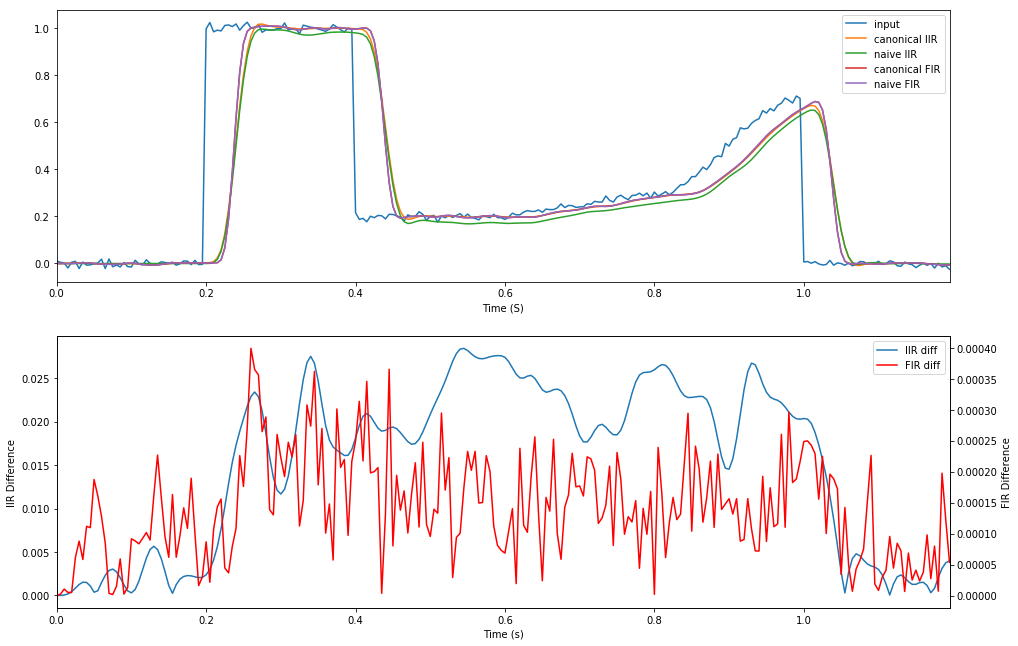

In [154]:
# We define our own dot product for use in C/C++
# len(x) must equal len(y)
def dotprod(x, y, num_bits):
    accum = x.dtype.type(0)
    for idx in range(len(x)):
        # In the C/C++ code use `>> num_bits` instead of
        # division with exponentiation, we do it this way
        # so as to be general whether we're dealing with
        # float or int here. E.g. just do:
        # accum += (x[idx] * y[idx]) >> num_bits;
        accum += x.dtype.type(((x[idx] * y[idx])/2**(num_bits)))
    return accum

# Shift x down, and place x_in on the end
def rotate(x, x_in):
    # Note that we check the length of x here because
    # if it is a zero-length array, we can just quit
    # and save ourselves the trouble of attempting the
    # x[-1] = x_in, which wouldn't work anyway.  This
    # is just so that we can be general for FIR and IIR
    # arrays, in practice we would optimize those out as
    # separate routines
    if not len(x):
        return
    
    for idx in range(len(x)-1,0,-1):
        x[idx] = x[idx-1]
    x[0] = x_in

# Given filter coefficients (`a` and `b`), the previous
# set of inputs (`x_prev`), the previous set of outputs
# (`y_prev`) and the new input sample, calculate the next
# output sample, updating x_prev and y_prev.
def naive_lfilter_sample(b, a, x_prev, y_prev, x_in, num_bits):
    # Shift the new value in
    rotate(x_prev, x_in)
    
    # Calculate output sample, omit second term here for FIR
    y_out = dotprod(b, x_prev, num_bits) - dotprod(a, y_prev, num_bits)
    
    # Update our y_prev array, omit this for FIR
    rotate(y_prev, y_out)
    
    return y_out

# Run a whole signal through as an example, even though
# in the C code, sample-by-sample filtering will be the
# way to go.  You can define the number of bits the input
# gets quantized to (num_bits) as well as the data type
# that the computation will take place with (compute_dtype).
# For our purposes, we will do our computation as int32
# with 16 bits of precision.  Note that we are actually
# showing the result with num_bits set to 15 instead of 16
# here, because the IIR filter overflows the 32bit registers
# if we actually scale to full (signed) 16 bit precision.
def naive_lfilter(b, a, x, compute_dtype=int32, num_bits=15):
    # We're dealing with signed data, so normalize to 2^(N-1)
    num_bits -= 1
    
    b = compute_dtype(around(b*(2.0**num_bits)))
    a = compute_dtype(around(a*(2.0**num_bits)))
    x = compute_dtype(around(x*(2.0**num_bits)))
    
    # Omit y_prev for FIR only
    x_prev = zeros(len(b), dtype=x.dtype)
    y_prev = zeros(len(a)-1, dtype=x.dtype)
    
    # We drop the leading value from a, it's not used in
    # the actual filtering, it's just a normalization term.
    # Furthermore, it should be 1.0.  In the C code, we can
    # drop this completely and just use the truncated,
    # normalized value for a.  We keep this just to conform
    # to other lfilter() algorithms. Omit this for FIR only.
    a = a[1:]
    
    # This is where we'll store our output
    y = zeros(len(x), dtype=x.dtype)
    for idx in range(len(x)):
        y[idx] = naive_lfilter_sample(b, a, x_prev, y_prev, x[idx], num_bits)
        
    # Return the filtered output
    return float32(y)/(2.0**num_bits)

# Now let's filter some stuff and compare with the canonical lfilter()
noisy = ground_truth + .01*randn(len(ground_truth))
t = arange(len(noisy))/fs
canonical_iir = lfilter(b_iir, a_iir, noisy)
canonical_fir = lfilter(b_fir, a_fir, noisy)
naive_iir = naive_lfilter(b_iir, a_iir, noisy)
naive_fir = naive_lfilter(b_fir, a_fir, noisy)

figure(figsize=(16,11))
subplot(211)
plot(t, noisy)
plot(t, canonical_iir)
plot(t, naive_iir)
plot(t, canonical_fir)
plot(t, naive_fir)
xlabel("Time (S)")
xlim(0, t[-1])
legend(["input", "canonical IIR", "naive IIR", "canonical FIR", "naive FIR"]);

ax1 = subplot(212)
line1 = ax1.plot(t, abs(canonical_iir - naive_iir))
ax1.set_ylabel("IIR Difference")
ax2 = ax1.twinx()
line2 = ax2.plot(t, abs(canonical_fir - naive_fir), 'red')
ax2.set_ylabel("FIR Difference")
xlim(0, t[-1])
ax1.set_xlabel("Time (s)")
legend(line1 + line2, ["IIR diff", "FIR diff"]);